# Lesson 2: Deep Learning for Coders

Lesson 2 goes a little deeper into computer vision and the fastai library by going a little deeper into the [DataBlocks](https://docs.fast.ai/data.block) and [DataLoaders](https://docs.fast.ai/data.load). 

The course notebook uses Bing Images to download image data, the idea being that we curate our own data set for this exercise. Fastai provides some methods and instructions for doing this, you can see details in the [notebook](https://github.com/fastai/course-v4/blob/master/nbs/02_production.ipynb)

I have taken a different route to gathering data. My goal for this notebook is to build a model that is able to classify musical pitches.

### Audio Data
- generate audio samples using MIDI.
    - I will not be worrying about sharps/flats simply to reduce complexity
    
- use [librosa](https://librosa.org/doc/latest/index.html) to process audio signals and generate [chromagrams](https://en.wikipedia.org/wiki/Chroma_feature#:~:text=Shifting%20the%20time%20window%20across,also%20referred%20to%20as%20chromagram.) using the [Constant Q Transform](https://en.wikipedia.org/wiki/Constant-Q_transform)
    - The Constant Q does a good job at isolating pitch but is not sensitive to octaves, thus, all audio samples are in the same octave.
    - https://dsp.stackexchange.com/questions/27572/why-does-this-constant-q-transform-lose-octaves

In [19]:
# !conda install -c conda-forge librosa -y

In [17]:
from fastai.vision.all import *
from fastai.vision.data import *

import matplotlib.pyplot as plt
# hi-res plots
%config InlineBackend.figure_format = 'retina'

from pathlib import Path

# sound library & widget to play audio
import librosa
import librosa.display
import IPython.display as ipd

## Load in Data

In [20]:
path = Path.cwd()

data_path = path/'lesson2_assets/cqt_data'
audio_file = path/'lesson2_assets/A3_1.wav'

# take a look at the filenames
data_path.ls()[1]

Path('/notebooks/lesson2_assets/cqt_data/A3_1.jpg')

### sidebar.. generating a chromagram

Below is a sample note (A3 on the piano) followed by a demonstration of how to generate a Constant-Q chromagram. The Y axis is displaying the note name for convenience. These were removed to create the training data set.

In [23]:
y, sr = librosa.load(audio_file, mono=True)
ipd.Audio(y, rate=sr)

In [83]:
doc(librosa.feature.chroma_cqt)

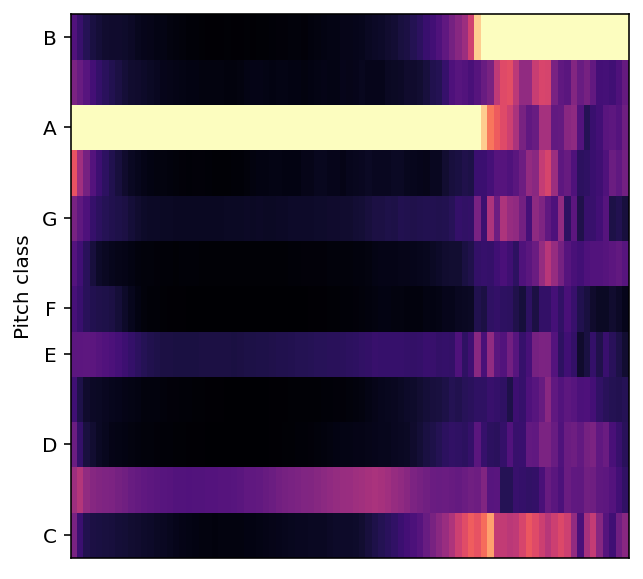

In [81]:
plt.figure(figsize=(5,5))

C = librosa.feature.chroma_cqt(y=y, sr=sr)

librosa.display.specshow(C, y_axis='chroma');

For comparison, here is the same note visualised using a spectrogram...

- "A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time." [wiki](https://en.wikipedia.org/wiki/Spectrogram)
- There is a lot more information within this plot (such as the fundamental frequency and harmonics above it), however using these images would make our classification task much harder.

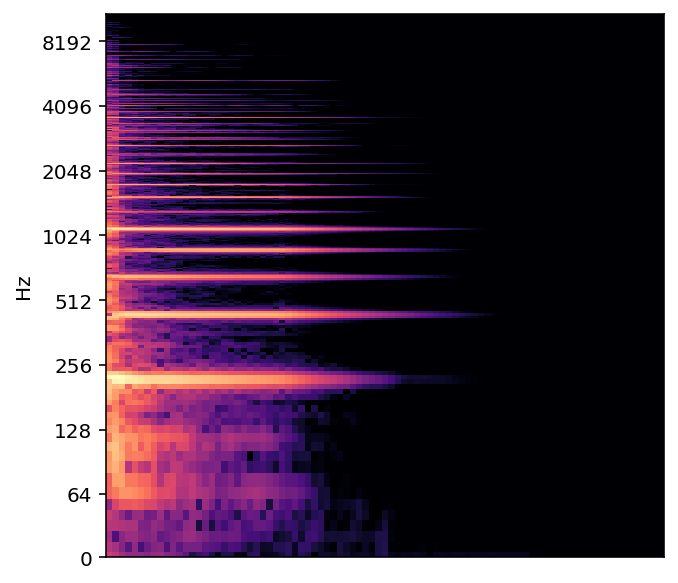

In [85]:
plt.figure(figsize=(5,5))

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

librosa.display.specshow(D, y_axis='log');

## Image Data

The filenames contain the classes that we are trying to predict. We need to define a function that will grab the first 2 characters of each file name to use as labels. This will look familiar to lesson one, excet we have more classes to predict

In [42]:
fnames = get_image_files(data_path)

In [43]:
def label_func(fname): return fname.name[:2]

label_func(fnames[37]) # verify the funciton works

'B3'

## From Data to DataLoader

**What is a DataBlock?**
- "The data block API takes its name from the way it's designed: every bit needed to build the DataLoaders object (type of inputs, targets, how to label, split...) is encapsulated in a block, and you can mix and match those blocks" - [docs](https://docs.fast.ai/tutorial.datablock)


**Breaking down the Block**
- the [tutorial](https://docs.fast.ai/tutorial.datablock) in the docs does a good job of stepping through building a block from scratch..

### Steps

1. Start with an empty `DataBlock`.
    - `dblock = DataBlock()`
2. Tell the block how you want to assemble your items using a `get_items` function.
    - we will use `get_image_files` as we did in lesson 1.
3. Let the block know how/where to get our labels from in `get_y`.
    - the lesson notebook uses `parent_label` which inherits the label from the parent folder. We need to use the `label_func` we created for this task.
4. Specify the types of our data (images and labels).
    - `ImageBlock` and `CategoryBlock`.
    - `blocks=(ImageBlock, CategoryBlock)`.
5. Decide how we want to split our data into training and valid datasets.
    - we will randomly split (80% training, 20% validation).
6. Specify any item transforms or batch transforms.

In [44]:
audio = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=label_func,
    item_tfms=Resize(128)
    )

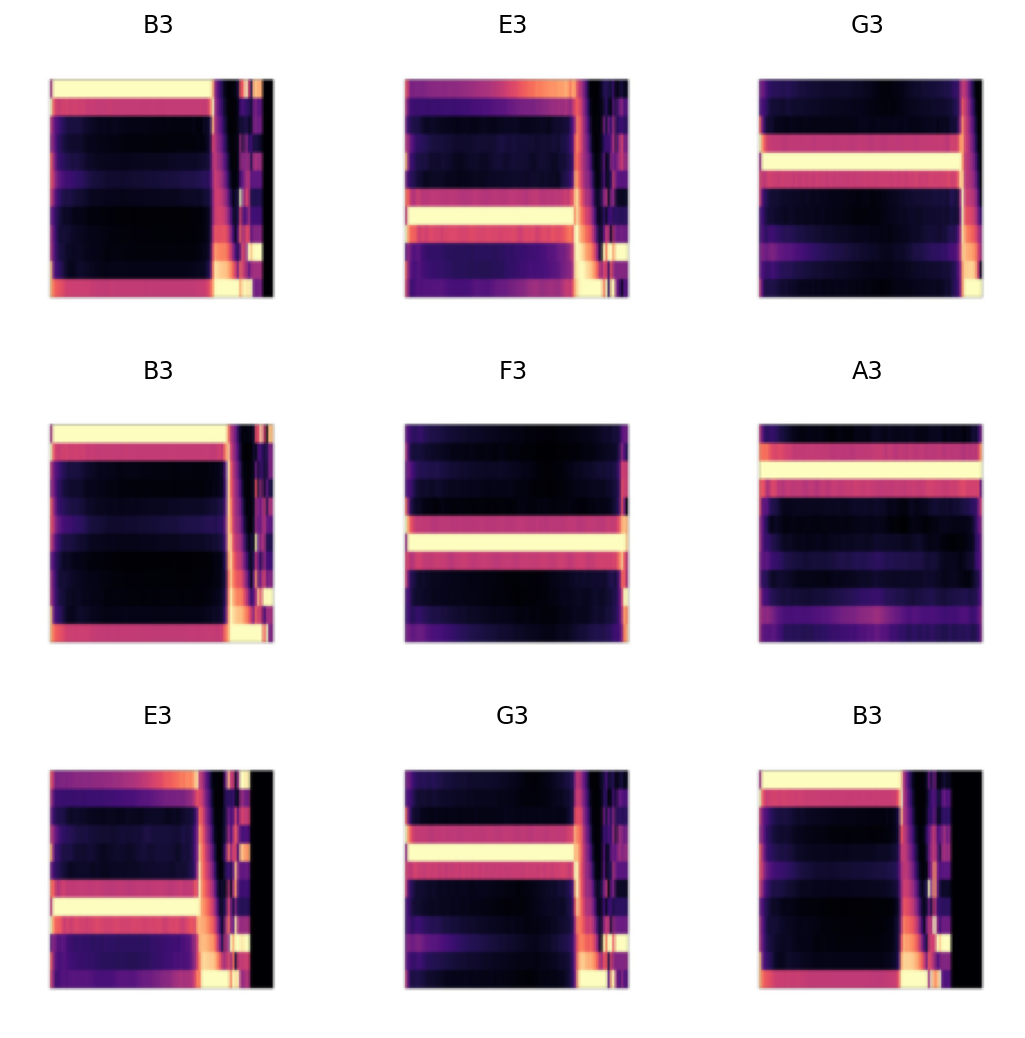

In [76]:
dls = audio.dataloaders(data_path, bs=32)

dls.show_batch()

## Sidebar: Data Augmentation and Transforms

fastai provides a number of [transforms](https://docs.fast.ai/vision.augment) that can be applied to data. In the case of computer vision, augmentation is useful for introducing variety into the dataset. Consider facial recognition, in production, you may not always be dealing with descent portraits; camera angle, lighting, perspective and lighting conditions may vary. Augmentation introduces some of these concepts into our traing and validation set.

In the context of the data I am working with, not all transformations may be useful. I would not expect these images to suffer from perspective warping or rotation, however, mirroring the image on the vertical could be useful, as could increasing and decreasing brightness and contrast.

Here is a quick example of how to apply some transforms to a batch of images at a time using `aug_transforms`

**I am not going to apply any of these for training in this notebook.**

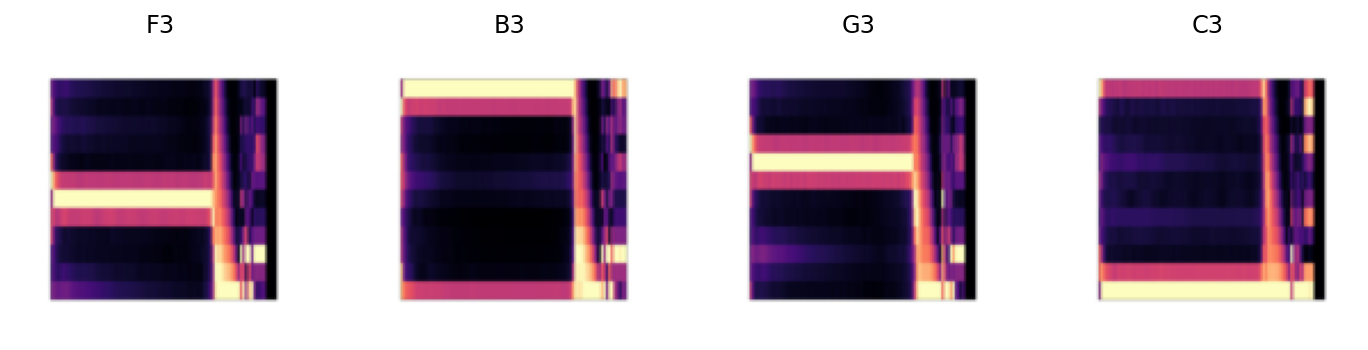

In [75]:
# no transformation applied
dls.valid.show_batch(max_n=4, nrows=1)

Here is a list of available transforms..

```python
aug_transforms(
    mult=1.0,
    do_flip=True,
    flip_vert=False,
    max_rotate=10.0,
    min_zoom=1.0,
    max_zoom=1.1,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75,
    xtra_tfms=None,
    size=None,
    mode='bilinear',
    pad_mode='reflection',
    align_corners=True,
    batch=False,
    min_scale=1.0,
)
```

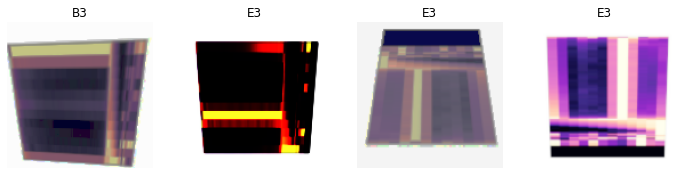

In [27]:
aug_tfms = aug_transforms(max_lighting=0.8, do_flip=True, flip_vert=True, max_rotate=0)

audio = audio.new(item_tfms=Resize(128), batch_tfms=aug_tfms)
dls = audio.dataloaders(data_path)
dls.train.show_batch(max_n=4, nrows=1)

### Create a `cnn_learner` and Train the model

In [46]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Before training, let's use `learn.lr_find` to help find a good learning rate. Two values are returned by running `lr_find`

- one tenth of the minimum before the divergence
- when the slope is the steepest

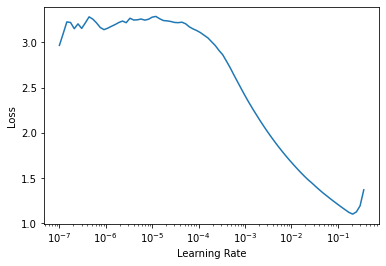

In [62]:
lr_min, lr_steep = learn.lr_find()

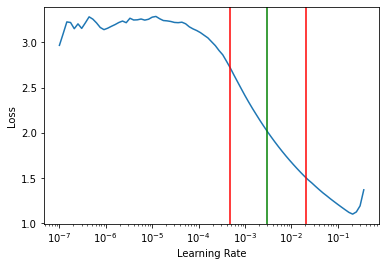

In [64]:
# plot the values returned by lr_find
learn.recorder.plot_lr_find()

plt.axvline(x=lr_min, color='red')
plt.axvline(x=3e-3, color='green')
plt.axvline(x=lr_steep, color='red');

I'm going to pick a value inbetween the suggested lr's for training.

In [65]:
lr_max = 3e-3

learn.fit_one_cycle(n_epoch=5, lr_max=lr_max)

epoch,train_loss,valid_loss,error_rate,time
0,2.412440,1.861958,0.642857,00:02
1,1.202116,0.856408,0.261905,00:01
2,0.763907,0.548905,0.190476,00:01
3,0.543375,0.206846,0.095238,00:01
4,0.412221,0.038176,0.023810,00:01


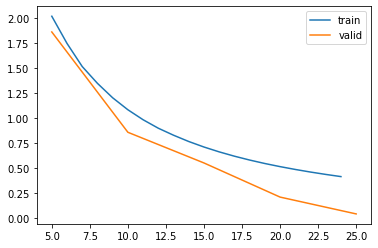

In [66]:
learn.recorder.plot_loss()

### Interpretation

- the model is performing quite well, only one note was incorrectly predicted (G3 predicted for F3 actual)

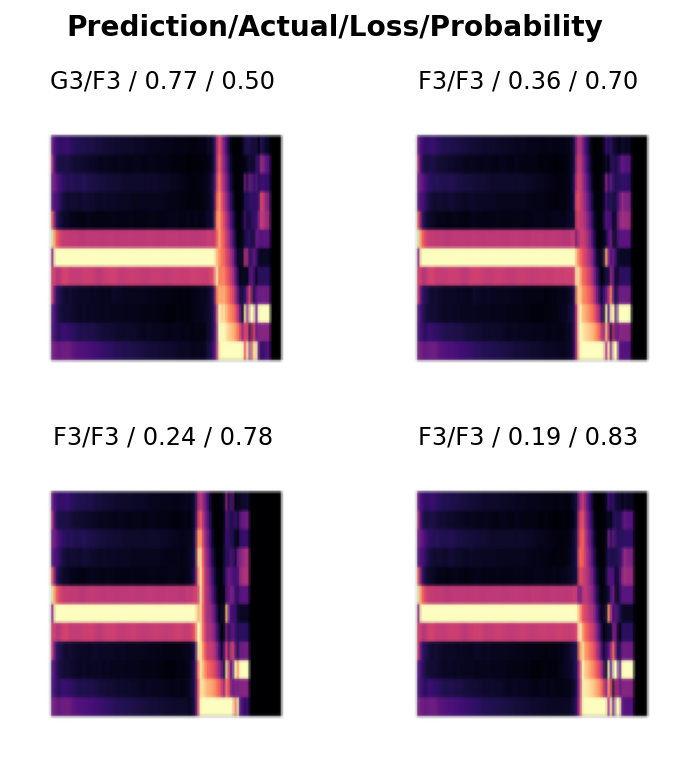

In [77]:
interp.plot_top_losses(k=4, figsize=(6,6))

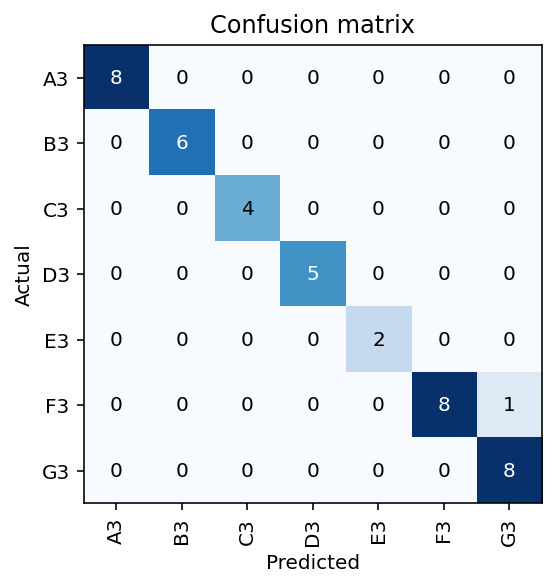

In [78]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [69]:
learn.save('base_cqt_model')

Path('models/base_cqt_model.pth')

Fine tune to try improve accuracy..

In [79]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.000892,0.002096,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.000499,0.000041,0.000000,00:02


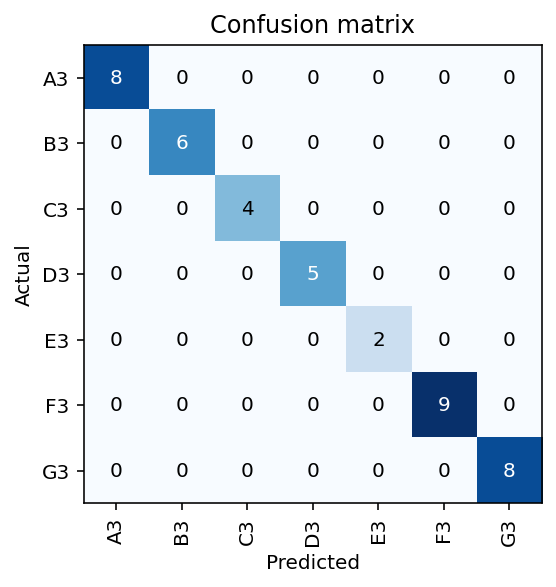

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Summary

This wasn't the hardest problem in the world. The Constant Q transform really simplifies pitch detection. I think this is an interesting problem space because there are opportunities to progress these examples; I'd like to try classify all 12 notes (by adding sharps/flats), then try multi-label classification using a phrase of notes, and hopefully then addressing the issue of identifying notes across octaves.